In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import scipy.spatial.distance
from scipy.special import erf
import math

import seaborn as sns

In [2]:
base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins'

folders = [
    'Wave_right_min_1',
    'Wave_right_min_2',
    'Wave_right_min_3',
    'Wave_right_min_4',
    'Wave_right_min_5'
]

file_names = ['Accelerometer.csv', 'Gyroscope.csv', 'Linear Accelerometer.csv', 'Magnetometer.csv']
sensor_types = ['accelerometer', 'gyroscope', 'linear_accelerometer', 'magnetometer']

# Function to construct file paths
def construct_file_paths(base_path, folders, file_names):
    file_paths = {}
    for sensor_type, file_name in zip(sensor_types, file_names):
        file_paths[sensor_type] = [os.path.join(base_path, folder, file_name) for folder in folders]
    return file_paths

file_paths = construct_file_paths(base_path, folders, file_names)

# Function to load data files and add labels
def load_and_label_data(file_paths, label):
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)
        # Add a label column
        df['label'] = label
        dfs.append(df)
    return dfs

# Load and label data for each sensor type
label = 'waving_righthand'
data_dict = {}
for sensor_type in sensor_types:
    data_dict[sensor_type] = load_and_label_data(file_paths[sensor_type], label)

# 1second Aggregate

In [3]:
# Function to create time intervals
def create_time_intervals(start_time, end_time, delta_t):
    return np.arange(start_time, end_time, delta_t)

# Function to aggregate data within time steps
def aggregate_data(df, time_column, delta_t, numerical_columns, label):
    start_time = df[time_column].min()
    end_time = df[time_column].max()
    time_intervals = create_time_intervals(start_time, end_time, delta_t)
    
    aggregated_data = []

    for t in time_intervals:
        window = df[(df[time_column] >= t) & (df[time_column] < t + delta_t)]
        if not window.empty:
            aggregated_row = {}
            aggregated_row['time'] = t
            for col in numerical_columns:
                aggregated_row[col] = window[col].mean()
            # Add the label to the aggregated row
            aggregated_row['label'] = label
            aggregated_data.append(aggregated_row)

    return pd.DataFrame(aggregated_data)

# Define time step and columns
delta_t = 1 

# Specify numerical columns for each sensor type
numerical_columns_dict = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Aggregate data for each sensor type in each folder
aggregated_data_dict = {sensor_type: [] for sensor_type in sensor_types}

for sensor_type in sensor_types:
    for df in data_dict[sensor_type]:
        aggregated_df = aggregate_data(df, 'Time (s)', delta_t, numerical_columns_dict[sensor_type], label)
        aggregated_data_dict[sensor_type].append(aggregated_df)


In [4]:
# Function to save aggregated data back into respective folders with modified filenames
def save_aggregated_data(base_path, folders, file_names, aggregated_data_dict, interval_label="1s"):
    for sensor_type, file_name in zip(sensor_types, file_names):
        for folder, df in zip(folders, aggregated_data_dict[sensor_type]):
            new_file_name = file_name.replace('.csv', f'_{interval_label}.csv')
            output_path = os.path.join(base_path, folder, new_file_name)
            df.to_csv(output_path, index=False)
            print(f"Saved aggregated data to {output_path}")

save_aggregated_data(base_path, folders, file_names, aggregated_data_dict)


Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_1/Accelerometer_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_2/Accelerometer_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_3/Accelerometer_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_4/Accelerometer_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_5/Accelerometer_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_1/Gyroscope_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_2/Gyroscope_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_3/Gyroscope_1s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mi

# Combined the data

In [9]:
# Define the sensor files and columns
sensor_files = {
    'accelerometer': 'Accelerometer_1s.csv',
    'gyroscope': 'Gyroscope_1s.csv',
    'linear_accelerometer': 'Linear Accelerometer_1s.csv',
    'magnetometer': 'Magnetometer_1s.csv'
}

# Load the dataset (specific to files ending with 0.25s.csv)
base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins'
folders = [
    'Wave_right_min_1',
    'Wave_right_min_2',
    'Wave_right_min_3',
    'Wave_right_min_4',
    'Wave_right_min_5'
]

def load_and_adjust_timestamps(base_path, folders, filename):
    combined_data = pd.DataFrame()
    for i, folder in enumerate(folders):
        file_path = os.path.join(base_path, folder, filename)
        if file_path.endswith('1s.csv'):
            df = pd.read_csv(file_path)
            combined_data = pd.concat([combined_data, df], ignore_index=True)
    
    # Adjust the timestamps to start at 0 and increment by 0.25s
    combined_data['time'] = np.arange(0, 1 * len(combined_data), 1)
    return combined_data

# Process each sensor file
for sensor_type, filename in sensor_files.items():
    combined_data = load_and_adjust_timestamps(base_path, folders, filename)
    output_path = os.path.join(base_path, f'Combined_{filename}')
    combined_data.to_csv(output_path, index=False)

print("Data concatenation and timestamp adjustment completed.")

Data concatenation and timestamp adjustment completed.


# EDA


First few rows of accelerometer data:
   time  X (m/s^2)  Y (m/s^2)  Z (m/s^2)             label
0     0   2.008837   6.672012   2.531004  waving_righthand
1     1   1.424429   4.262147   2.567060  waving_righthand
2     2  -0.695145   3.919710  -0.554486  waving_righthand
3     3  -2.041081   3.689120  -2.069692  waving_righthand
4     4  -0.539772   4.042405  -0.509034  waving_righthand

Summary statistics of accelerometer data:
             time   X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  303.000000  303.000000  303.000000  303.000000
mean   151.000000   -1.371713   -0.540689    2.288597
std     87.612784    3.769411    4.762069    2.782546
min      0.000000  -19.577039  -17.323696   -4.879653
25%     75.500000   -3.446558   -3.172486    0.366861
50%    151.000000   -1.440733    0.355470    2.566180
75%    226.500000    0.636301    2.406490    4.059738
max    302.000000   30.706994    9.893447   13.162728

Missing values in accelerometer data:
time         0
X (m/s^2)    0
Y (m/s^2)

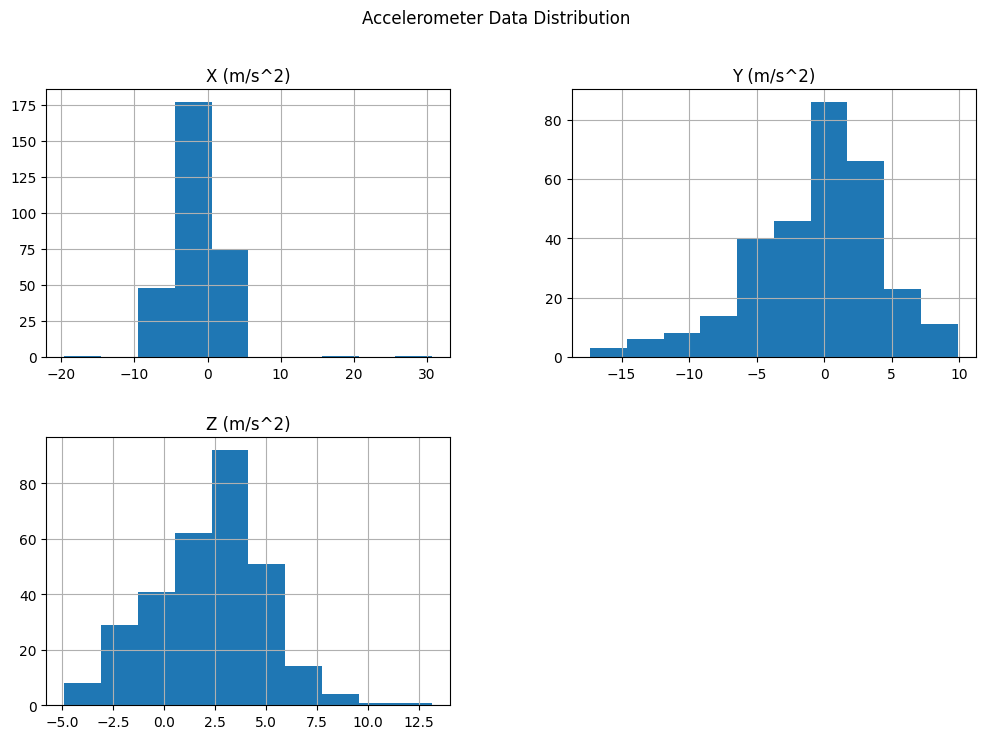

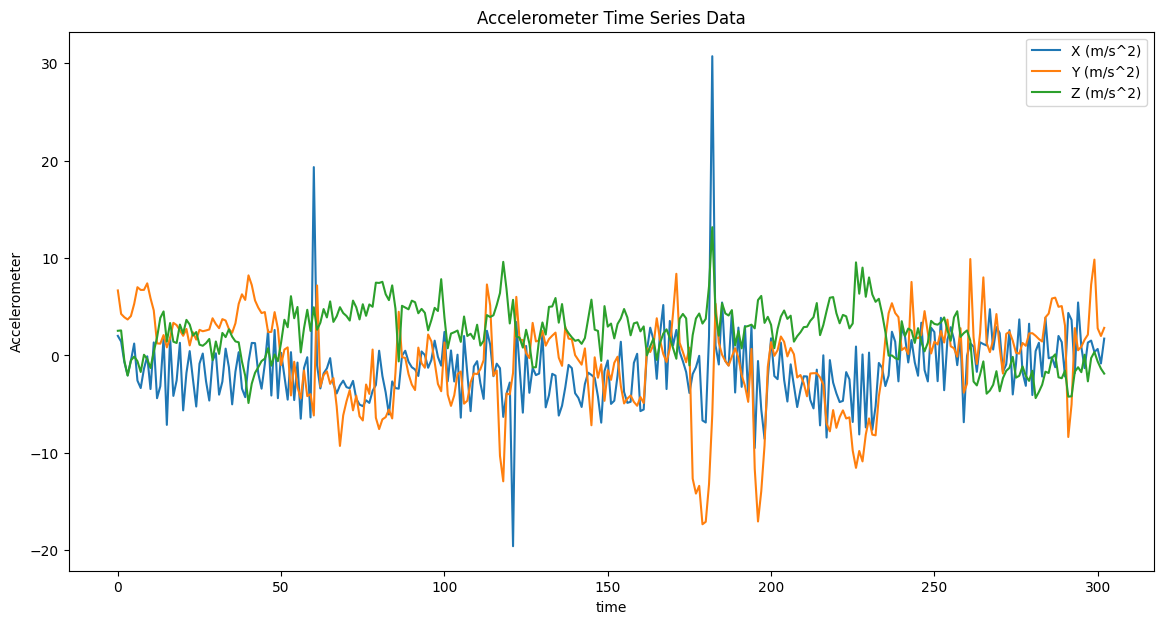

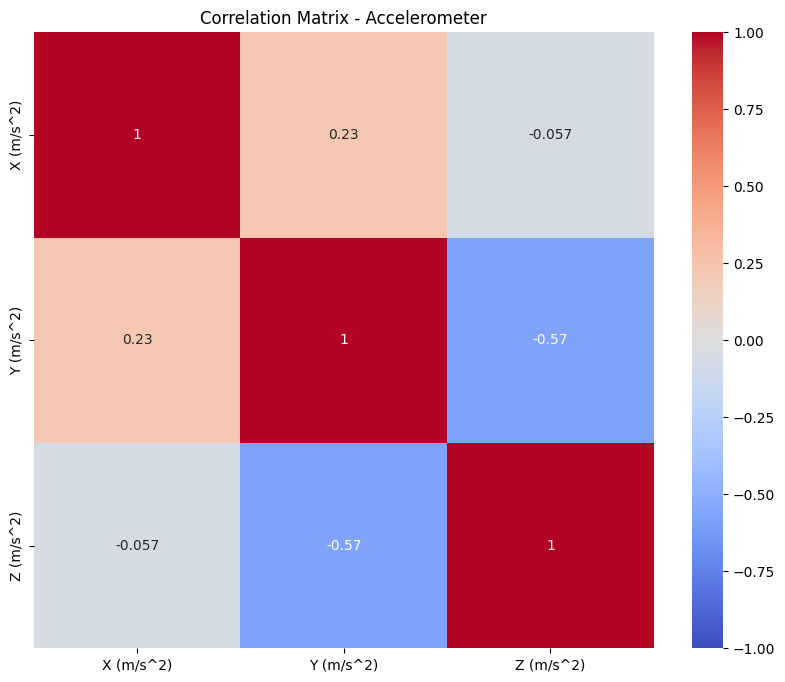


First few rows of gyroscope data:
   time  X (rad/s)  Y (rad/s)  Z (rad/s)             label
0     0   0.517308  -1.358160  -1.024147  waving_righthand
1     1  -0.046583  -0.452744   1.069719  waving_righthand
2     2   0.598959  -0.067875  -1.446300  waving_righthand
3     3   0.187089  -0.497023   1.242747  waving_righthand
4     4   0.399486   0.064898  -1.067960  waving_righthand

Summary statistics of gyroscope data:
             time   X (rad/s)   Y (rad/s)   Z (rad/s)
count  301.000000  301.000000  301.000000  301.000000
mean   150.000000    0.272311   -0.029773    0.086288
std     87.035433    0.425200    0.434390    0.936884
min      0.000000   -2.813387   -1.452371   -1.896337
25%     75.000000    0.020487   -0.254154   -0.473007
50%    150.000000    0.302468   -0.031823    0.061694
75%    225.000000    0.519161    0.185358    0.609541
max    300.000000    1.628700    2.410328    8.012442

Missing values in gyroscope data:
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad

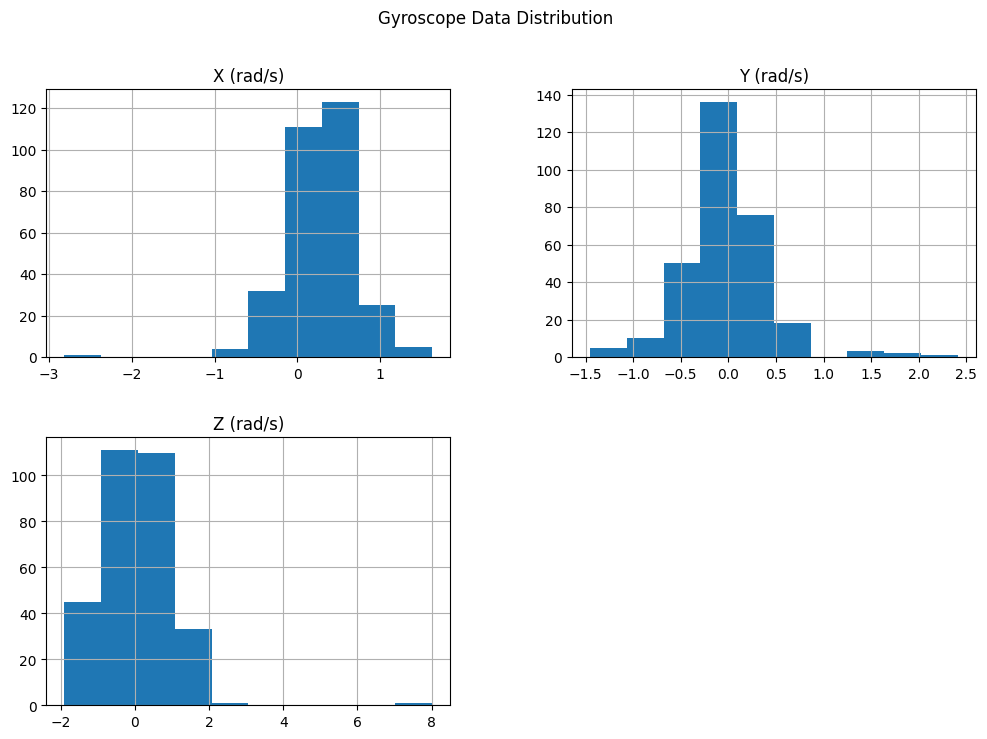

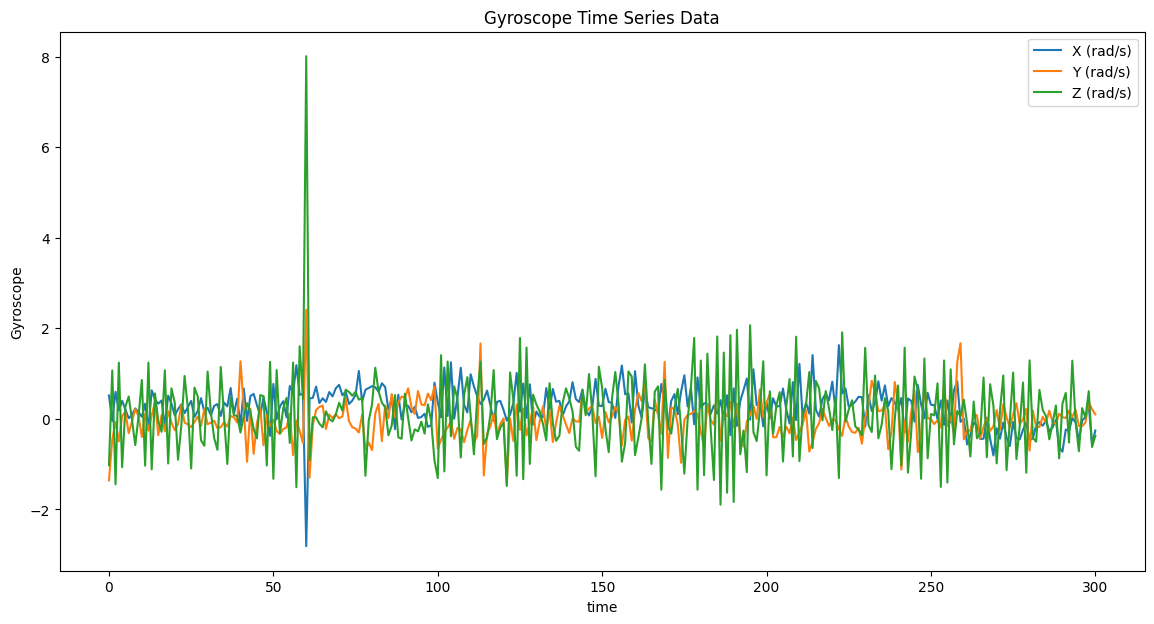

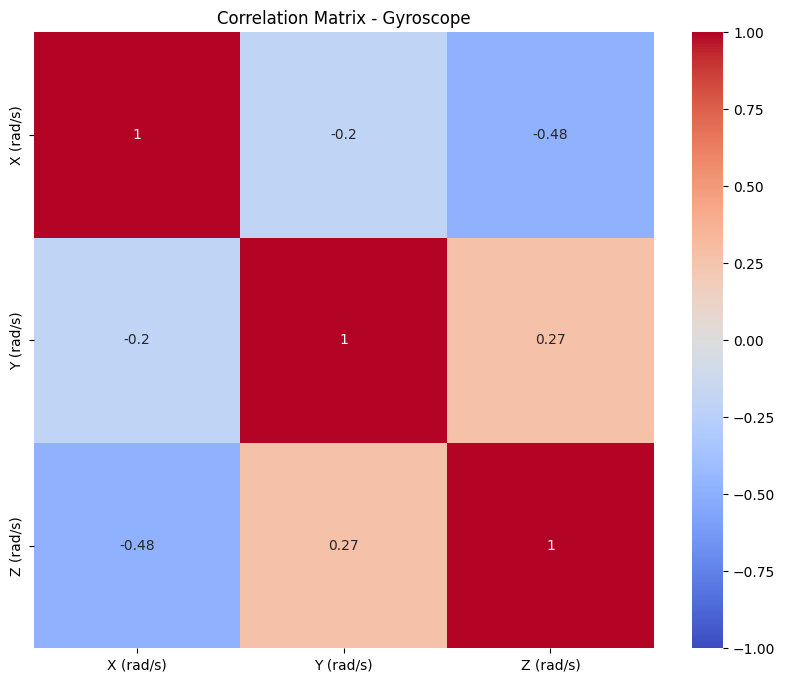


First few rows of linear_accelerometer data:
   time  X (m/s^2)  Y (m/s^2)  Z (m/s^2)             label
0     0  -0.509551  -1.199569   0.254464  waving_righthand
1     1   0.644713  -3.943030   0.498963  waving_righthand
2     2   0.286349  -4.802092  -0.756001  waving_righthand
3     3   0.089525  -4.846741  -1.620075  waving_righthand
4     4   0.701949  -4.688974  -0.375970  waving_righthand

Summary statistics of linear_accelerometer data:
             time   X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  301.000000  301.000000  301.000000  301.000000
mean   150.000000    0.470541   -8.297380    0.744653
std     87.035433    2.075899    3.915372    1.510528
min      0.000000   -5.253738  -21.196157   -2.538403
25%     75.000000   -0.855741  -10.552438   -0.332987
50%    150.000000    0.472092   -7.564053    0.540562
75%    225.000000    1.767322   -5.902804    1.761038
max    300.000000   17.883820    0.533413    5.876429

Missing values in linear_accelerometer data:
time         0
X (

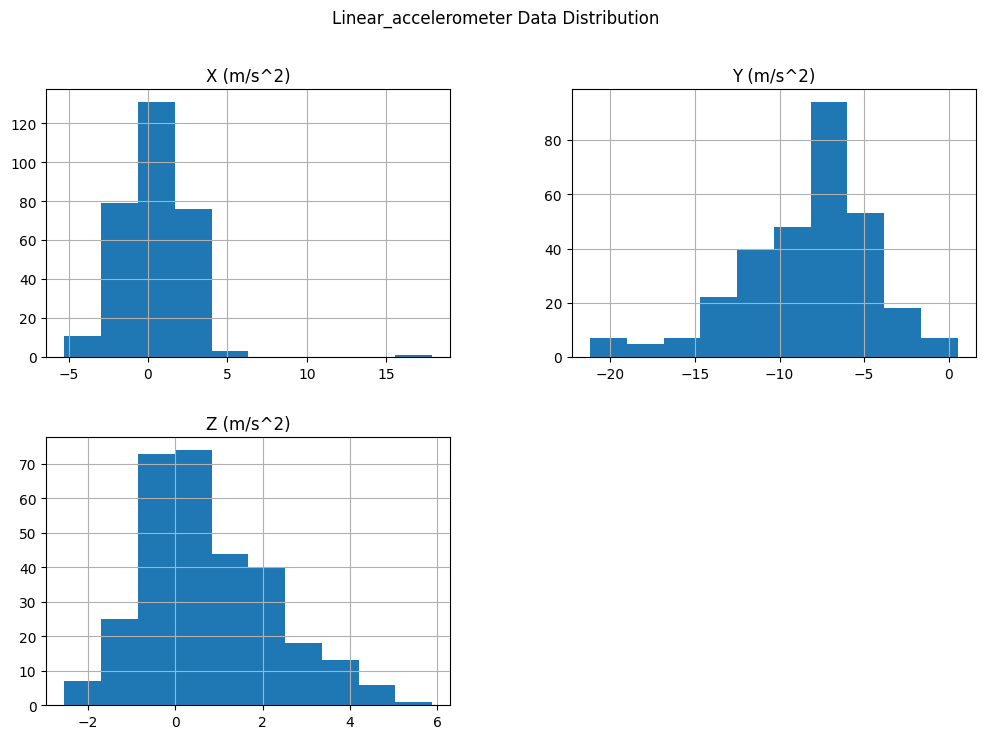

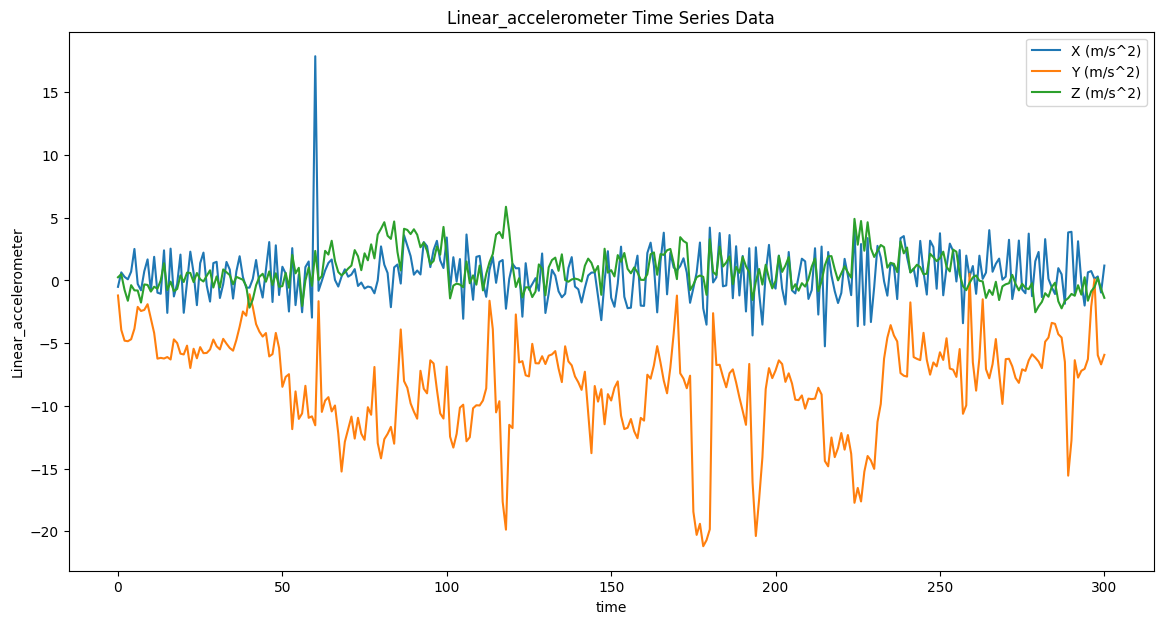

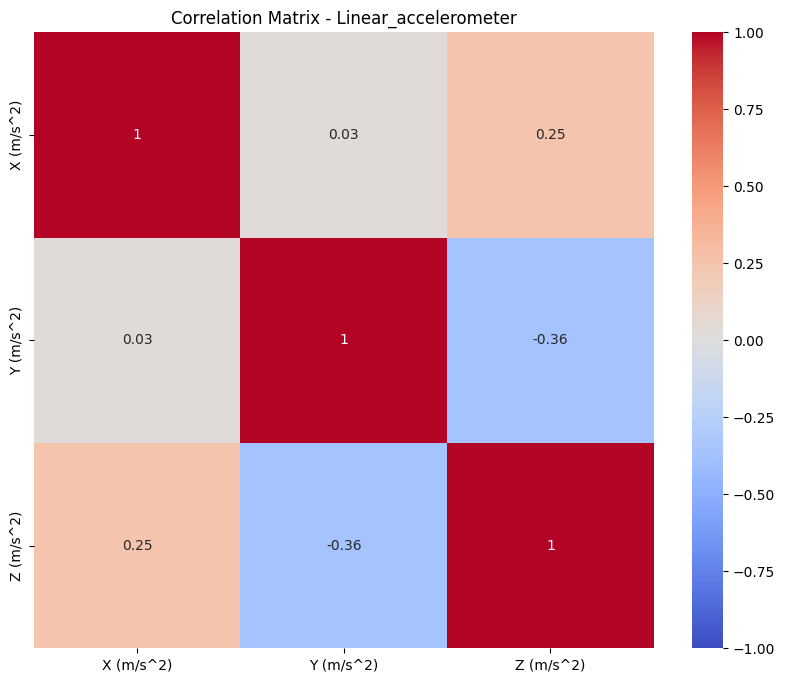


First few rows of magnetometer data:
   time      X (µT)      Y (µT)      Z (µT)             label
0     0  258.626752 -926.624417  619.446086  waving_righthand
1     1  282.318160 -922.866877  606.630480  waving_righthand
2     2  286.671143 -920.588076  601.641660  waving_righthand
3     3  288.214646 -919.291083  602.572850  waving_righthand
4     4  286.360097 -920.540135  600.189287  waving_righthand

Summary statistics of magnetometer data:
             time      X (µT)      Y (µT)      Z (µT)
count  301.000000  301.000000  301.000000  301.000000
mean   150.000000   61.070166 -175.813454   94.110720
std     87.035433  102.206093  334.031438  227.881584
min      0.000000  -22.005771 -926.624417  -28.551880
25%     75.000000   17.278889  -31.867043  -19.976398
50%    150.000000   21.536179  -26.973798   -8.841839
75%    225.000000   25.911619  -23.078317   19.538075
max    300.000000  294.243498   -5.558359  628.666940

Missing values in magnetometer data:
time      0
X (µT)    0


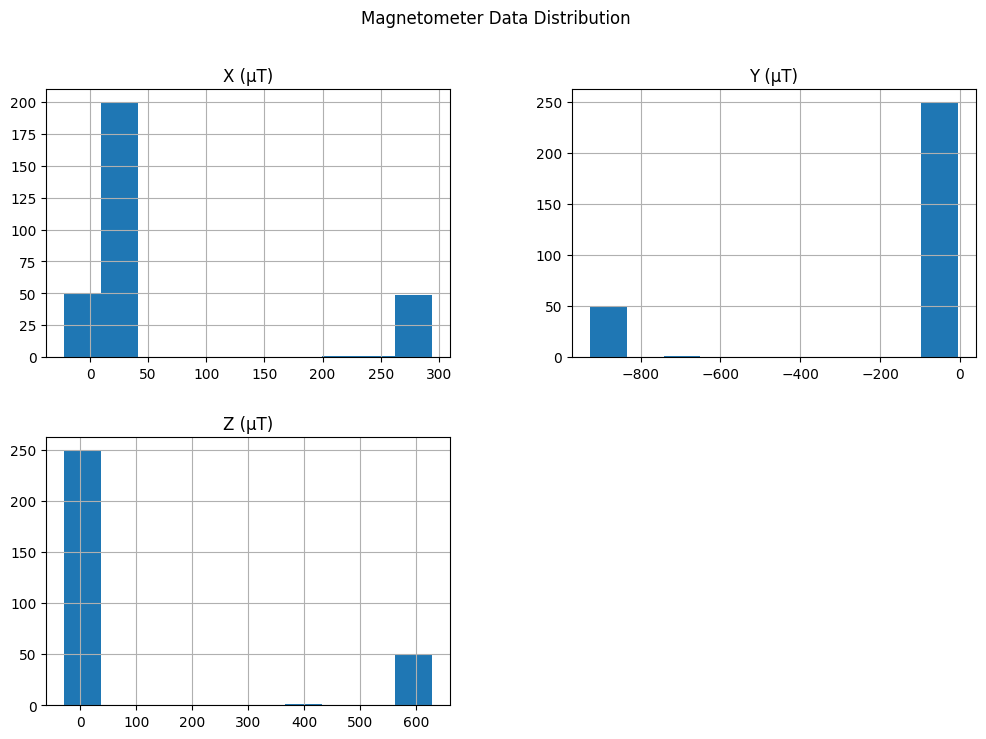

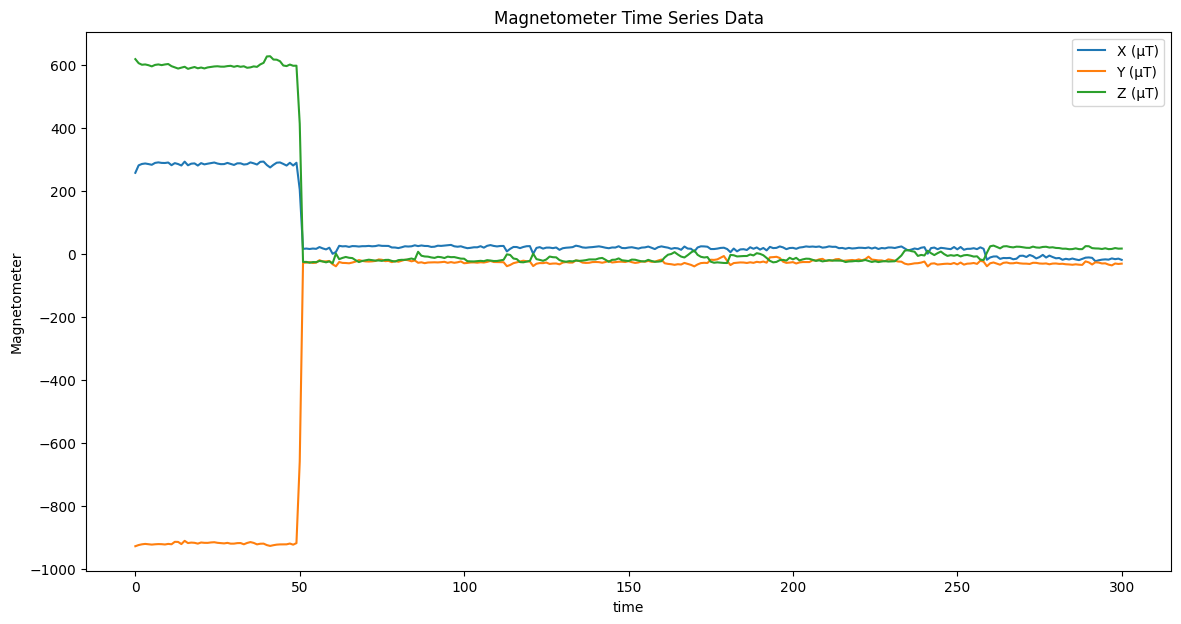

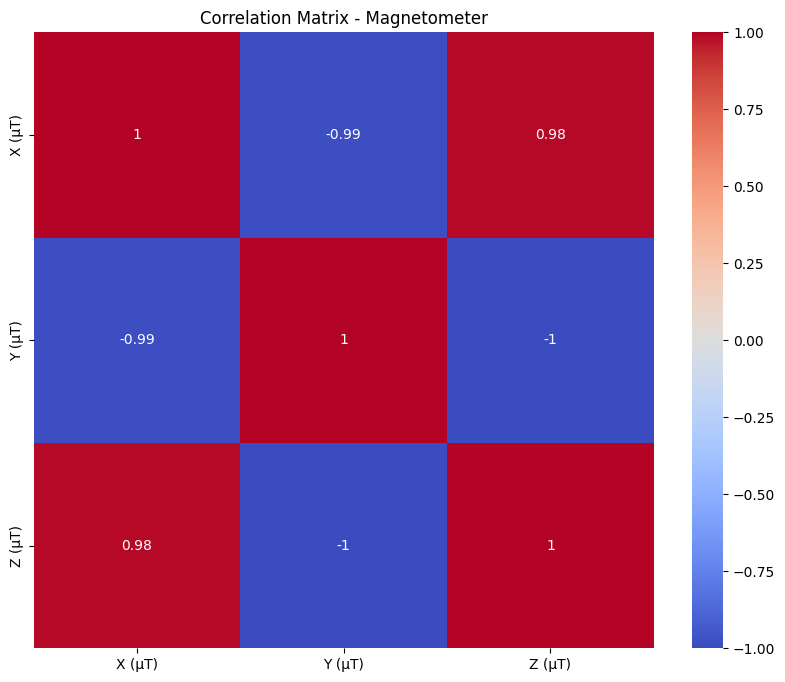

EDA completed.


In [10]:
# Define the sensor files and columns
sensor_files = {
    'accelerometer': 'Combined_Accelerometer_1s.csv',
    'gyroscope': 'Combined_Gyroscope_1s.csv',
    'linear_accelerometer': 'Combined_Linear Accelerometer_1s.csv',
    'magnetometer': 'Combined_Magnetometer_1s.csv'
}

sensor_columns = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Define the base path
base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Combined Data 1s'

def perform_eda(filename, sensor_type, cols):
    file_path = os.path.join(base_path, filename)
    df = pd.read_csv(file_path)

    # Display the first few rows of the data
    print(f"\nFirst few rows of {sensor_type} data:")
    print(df.head())

    # Display summary statistics
    print(f"\nSummary statistics of {sensor_type} data:")
    print(df.describe())

    # Check for missing values
    print(f"\nMissing values in {sensor_type} data:")
    print(df.isnull().sum())

    # Plot histograms for each sensor column
    df[cols].hist(figsize=(12, 8))
    plt.suptitle(f'{sensor_type.capitalize()} Data Distribution')
    plt.show()

    # Plot time series for each sensor column
    plt.figure(figsize=(14, 7))
    for col in cols:
        plt.plot(df['time'], df[col], label=col)
    plt.title(f'{sensor_type.capitalize()} Time Series Data')
    plt.xlabel('time')
    plt.ylabel(sensor_type.capitalize())
    plt.legend()
    plt.show()

    # Compute and visualize the correlation matrix
    corr_matrix = df[cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix - {sensor_type.capitalize()}')
    plt.show()

# Perform EDA on each combined file
for sensor_type, filename in sensor_files.items():
    cols = sensor_columns[sensor_type]
    perform_eda(filename, sensor_type, cols)

print("EDA completed.")


# Normality Check

Accelerometer Data Normality Check:


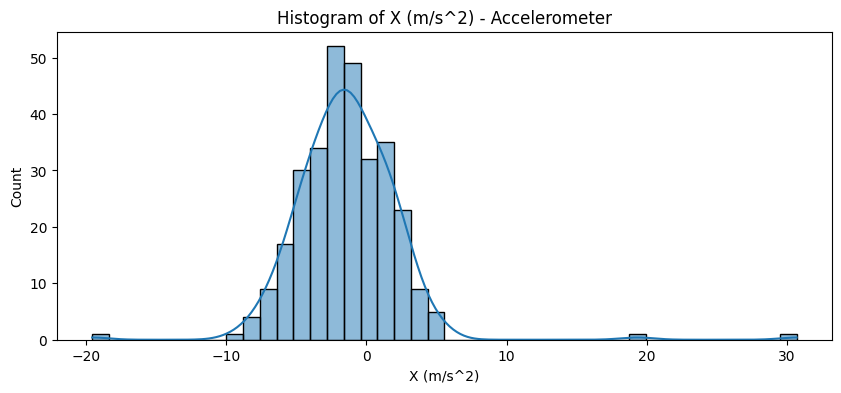

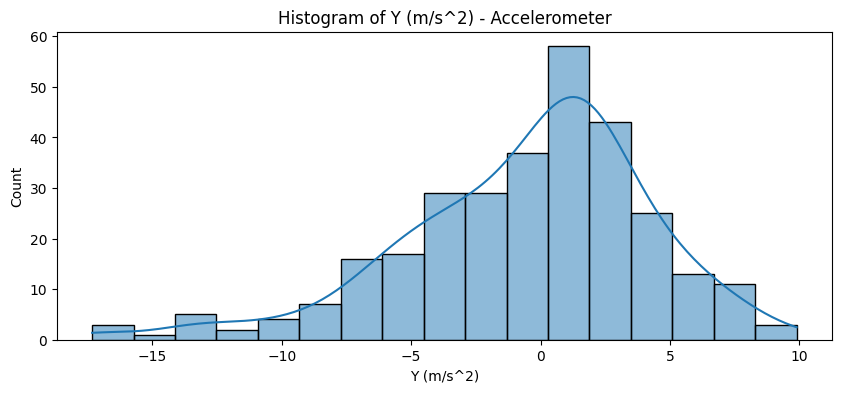

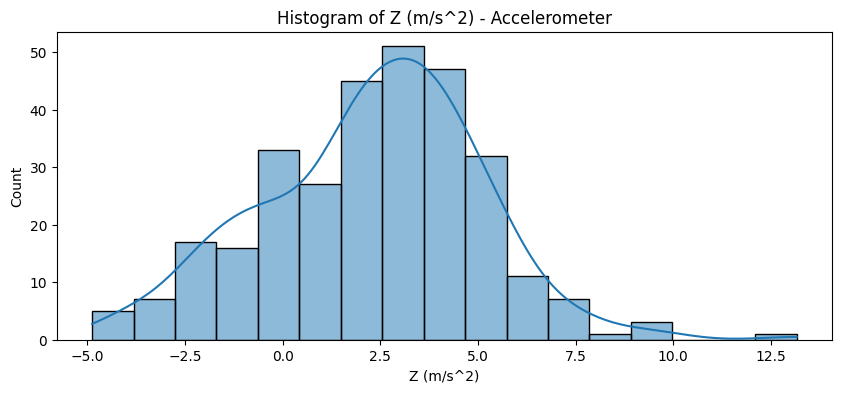

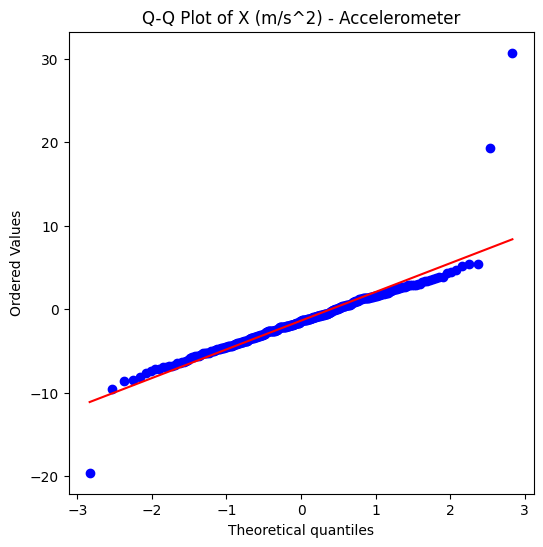

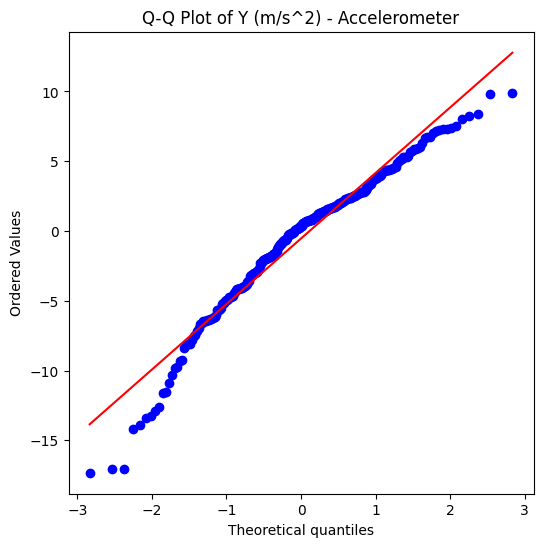

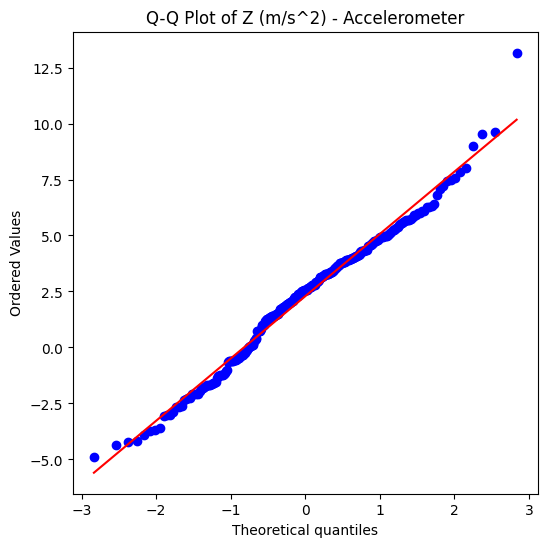

Shapiro-Wilk Test for X (m/s^2) - Accelerometer: Statistics=8.333e-01, p=2.158e-17
X (m/s^2) - Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (m/s^2) - Accelerometer: Statistics=9.597e-01, p=1.996e-07
Y (m/s^2) - Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (m/s^2) - Accelerometer: Statistics=9.867e-01, p=6.720e-03
Z (m/s^2) - Accelerometer does not look Gaussian (reject H0)

Gyroscope Data Normality Check:


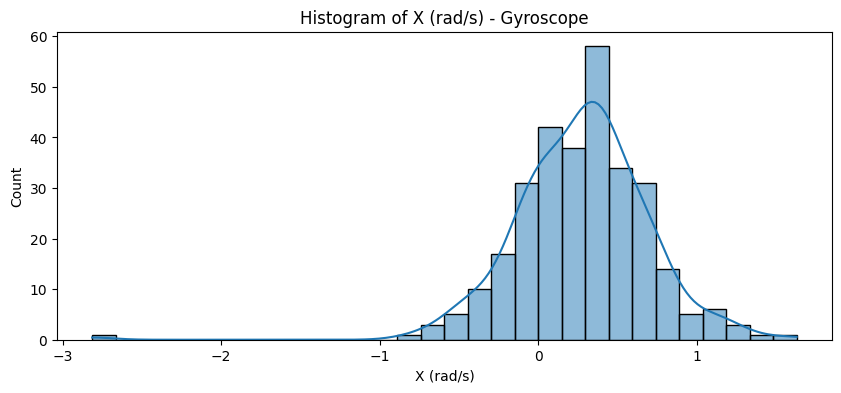

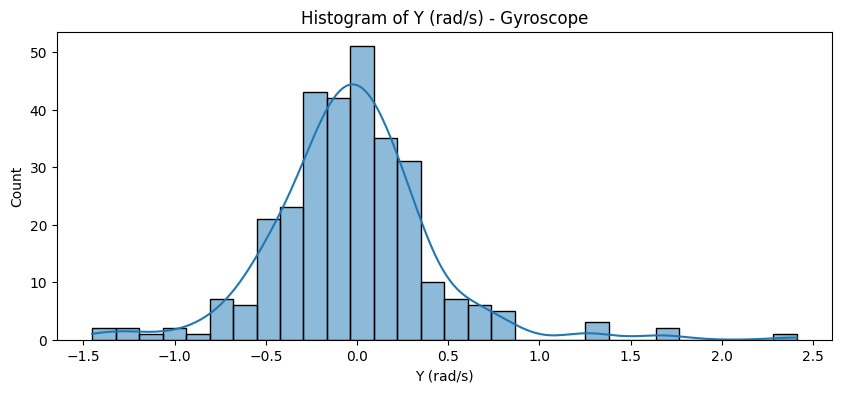

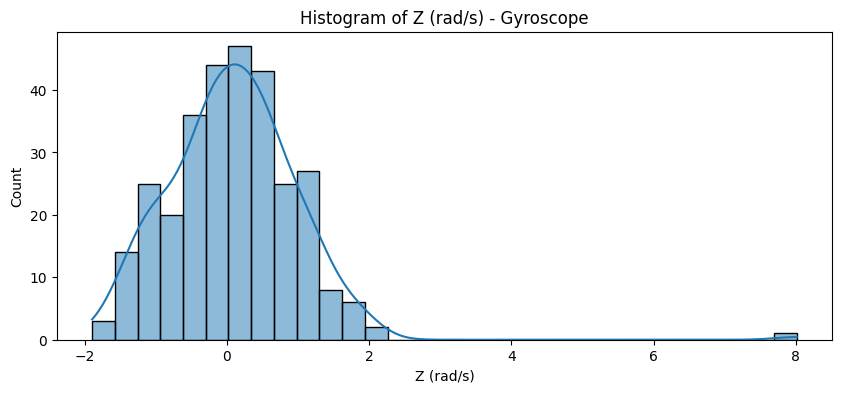

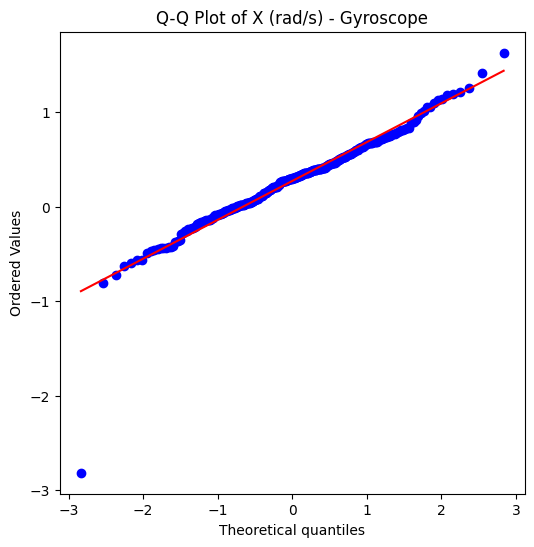

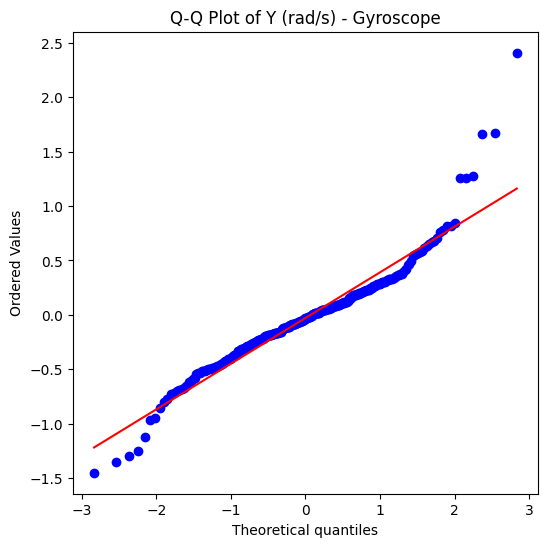

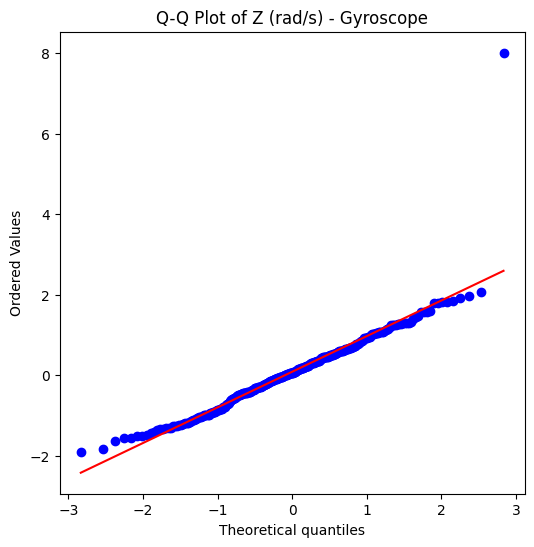

Shapiro-Wilk Test for X (rad/s) - Gyroscope: Statistics=9.319e-01, p=1.625e-10
X (rad/s) - Gyroscope does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (rad/s) - Gyroscope: Statistics=9.296e-01, p=9.850e-11
Y (rad/s) - Gyroscope does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (rad/s) - Gyroscope: Statistics=8.891e-01, p=5.362e-14
Z (rad/s) - Gyroscope does not look Gaussian (reject H0)

Linear Accelerometer Data Normality Check:


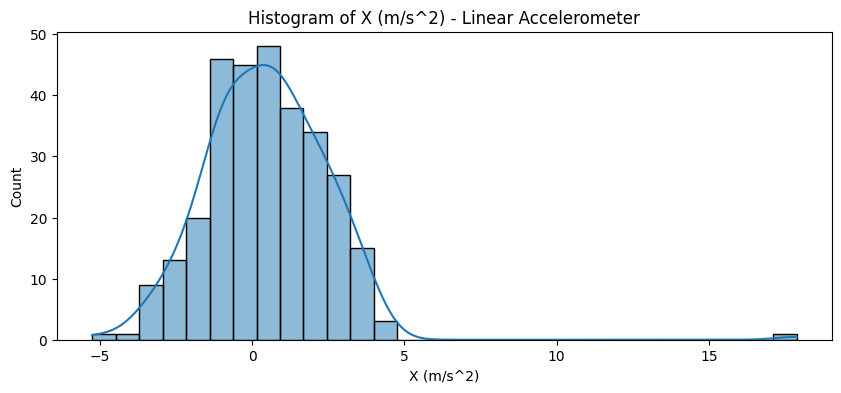

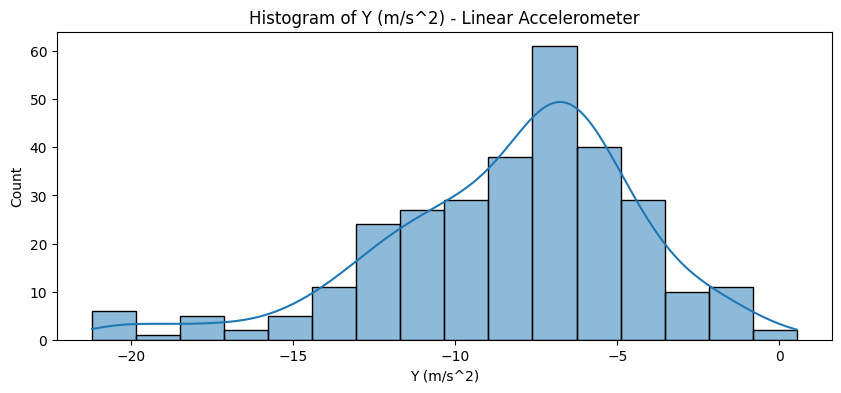

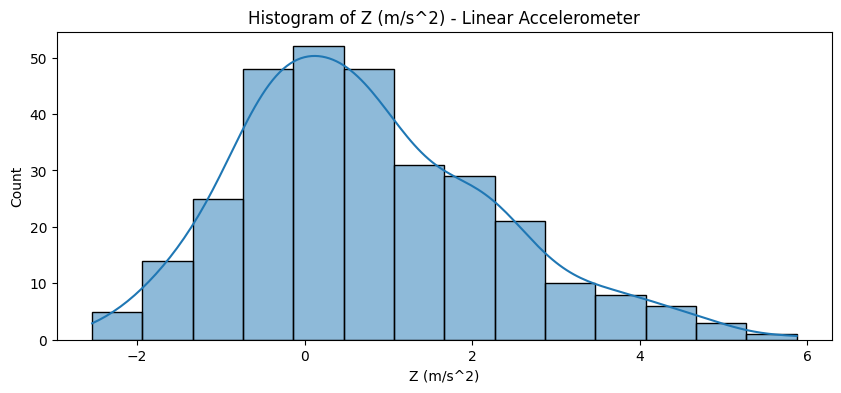

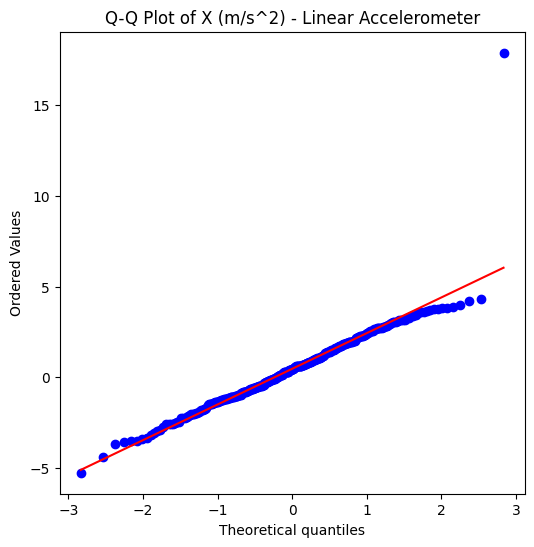

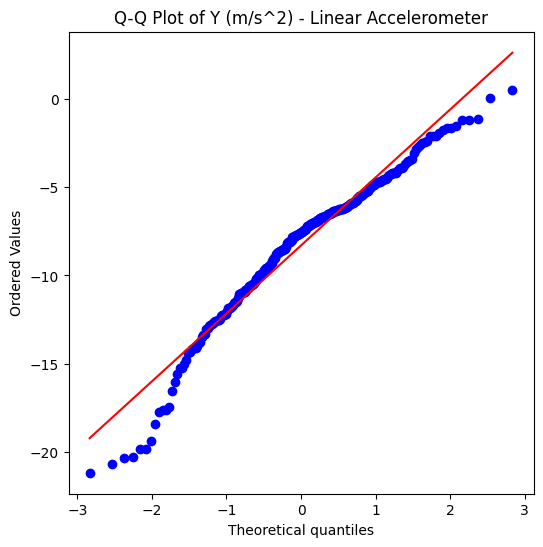

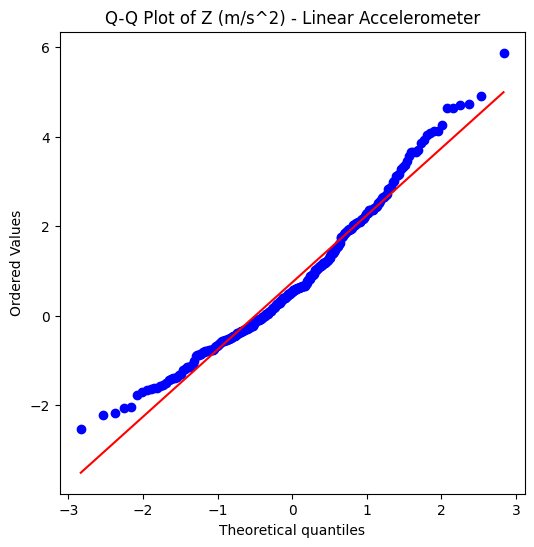

Shapiro-Wilk Test for X (m/s^2) - Linear Accelerometer: Statistics=8.935e-01, p=1.099e-13
X (m/s^2) - Linear Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (m/s^2) - Linear Accelerometer: Statistics=9.589e-01, p=1.702e-07
Y (m/s^2) - Linear Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (m/s^2) - Linear Accelerometer: Statistics=9.728e-01, p=1.821e-05
Z (m/s^2) - Linear Accelerometer does not look Gaussian (reject H0)

Magnetometer Data Normality Check:


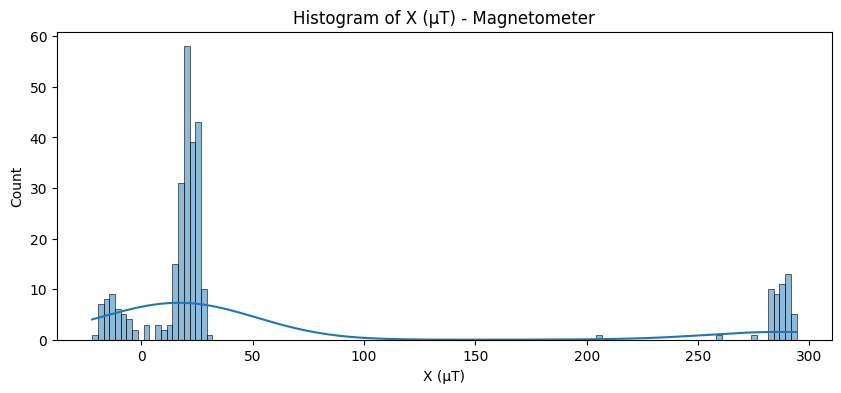

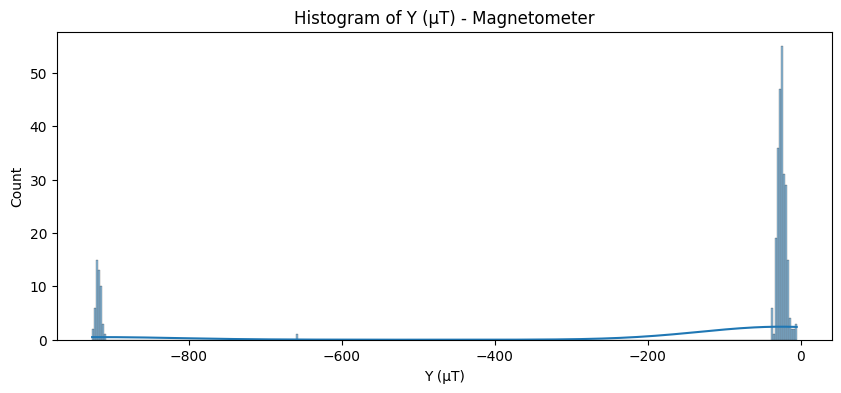

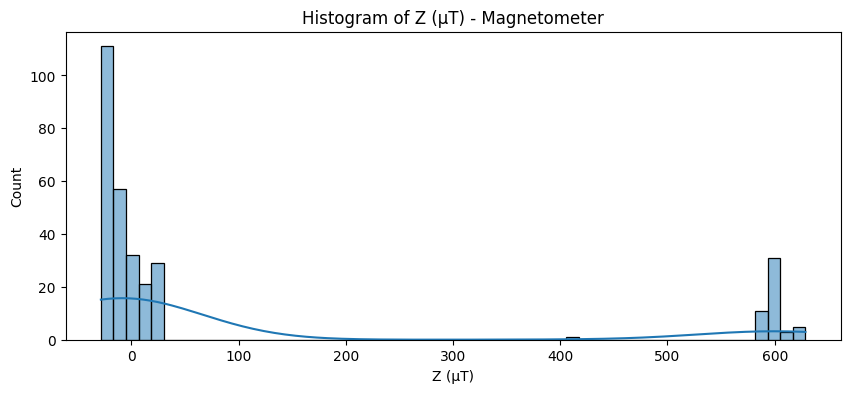

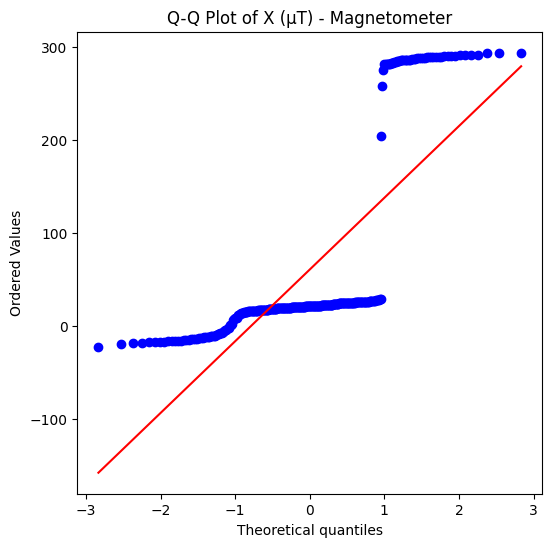

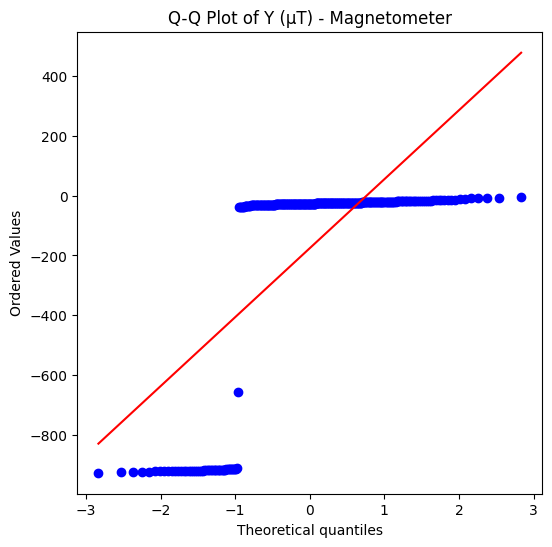

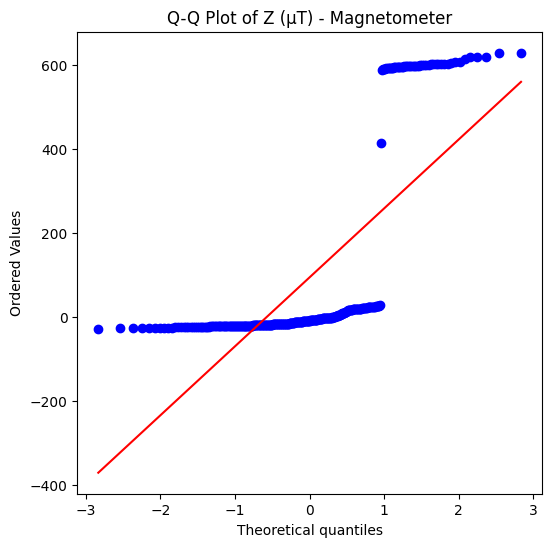

Shapiro-Wilk Test for X (µT) - Magnetometer: Statistics=5.607e-01, p=7.573e-27
X (µT) - Magnetometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (µT) - Magnetometer: Statistics=4.692e-01, p=5.773e-29
Y (µT) - Magnetometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (µT) - Magnetometer: Statistics=5.108e-01, p=4.843e-28
Z (µT) - Magnetometer does not look Gaussian (reject H0)


In [11]:

base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins'
folders = [
'Combined Data 1s']

def agg_data(base_path, folders, filename):
    data_frames = []
    for folder in folders:
        file_path = os.path.join(base_path, folder, filename)
        df = pd.read_csv(file_path)
        data_frames.append(df)
    combined_data = pd.concat(data_frames, ignore_index=True)
    return combined_data

# Load the aggregated data
accel_data = agg_data(base_path, folders, 'Combined_Accelerometer_1s.csv')
gyro_data = agg_data(base_path, folders, 'Combined_Gyroscope_1s.csv')
linear_accel_data = agg_data(base_path, folders, 'Combined_Linear Accelerometer_1s.csv')
magnetometer_data = agg_data(base_path, folders, 'Combined_Magnetometer_1s.csv')

# Check for normality using visual methods and statistical tests

# Function to plot histograms
def plot_histograms(data, cols, sensor):
    for col in cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(data[col], kde=True)
        plt.title(f'Histogram of {col} - {sensor}')
        plt.show()

# Function to plot Q-Q plots
def plot_qq(data, cols, sensor):
    for col in cols:
        plt.figure(figsize=(6, 6))
        stats.probplot(data[col], dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {col} - {sensor}')
        plt.show()

# Function to perform Shapiro-Wilk Test
def shapiro_test(data, cols, sensor):
    for col in cols:
        stat, p = stats.shapiro(data[col])
        print(f'Shapiro-Wilk Test for {col} - {sensor}: Statistics={stat:.3e}, p={p:.3e}')
        if p > 0.05:
            print(f'{col} - {sensor} looks Gaussian (fail to reject H0)')
        else:
            print(f'{col} - {sensor} does not look Gaussian (reject H0)')


# Columns to check for normality for each sensor
columns = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Perform checks on accelerometer data
print("Accelerometer Data Normality Check:")
plot_histograms(accel_data, columns['accelerometer'], 'Accelerometer')
plot_qq(accel_data, columns['accelerometer'], 'Accelerometer')
shapiro_test(accel_data, columns['accelerometer'], 'Accelerometer')

# Perform checks on gyroscope data
print("\nGyroscope Data Normality Check:")
plot_histograms(gyro_data, columns['gyroscope'], 'Gyroscope')
plot_qq(gyro_data, columns['gyroscope'], 'Gyroscope')
shapiro_test(gyro_data, columns['gyroscope'], 'Gyroscope')

# Perform checks on linear accelerometer data
print("\nLinear Accelerometer Data Normality Check:")
plot_histograms(linear_accel_data, columns['linear_accelerometer'], 'Linear Accelerometer')
plot_qq(linear_accel_data, columns['linear_accelerometer'], 'Linear Accelerometer')
shapiro_test(linear_accel_data, columns['linear_accelerometer'], 'Linear Accelerometer')

# Perform checks on magnetometer data
print("\nMagnetometer Data Normality Check:")
plot_histograms(magnetometer_data, columns['magnetometer'], 'Magnetometer')
plot_qq(magnetometer_data, columns['magnetometer'], 'Magnetometer')
shapiro_test(magnetometer_data, columns['magnetometer'], 'Magnetometer')